In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

%matplotlib inline

In [2]:
df = pd.read_json('transactions.txt', lines=True)

df.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


## Data Cleaning

In [3]:
# Replacing white space with nan

df = df.replace('', np.nan)

C:\Users\brian\AppData\Local\Temp\ipykernel_34736\2814523631.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('', np.nan)


In [4]:
# Checking which columns are empty and removing

nan_col = df.columns[df.isna().all()].tolist()
df.drop(columns=nan_col, inplace=True)

print("Empty columns that were removed:")
print(nan_col)

Empty columns that were removed:
['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd']


In [5]:
# Account Number and Customer Id columns appear to be equal

df['accountNumber'].equals(df['customerId'])

True

In [6]:
# Removing customerId as it is a duplicate of accountNumber

df.drop(columns=['customerId'], inplace=True)

In [7]:
# Dropping merchantName as merchantCategory will be used
df.drop(columns=['merchantName'], inplace=True)

In [8]:
# Need to remove remaining unneeded columns
#df.drop(columns=['cardCVV'], inplace=True)
#df.drop(columns=['enteredCVV'], inplace=True)
df.drop(columns=['cardLast4Digits'], inplace=True)

In [9]:
# Filling NaN with purchase to keep data

df['transactionType'] = df['transactionType'].fillna('PURCHASE')

In [10]:
# Total amount of rows with NaN values
df.isnull().any(axis=1).sum()

9003

In [11]:
# Dropping all rows with NaN value
df = df.dropna()

In [12]:
pd.pandas.set_option('display.max_columns', None)

In [13]:
# Changing transactionDatetime. All transactions occurred in 2016, year is unneeded.

df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'])
df['Month'] = df['transactionDateTime'].dt.month
df['day'] = df['transactionDateTime'].dt.day
df['hour'] = df['transactionDateTime'].dt.hour
df['minute'] = df['transactionDateTime'].dt.minute

# Cyclic encoding for hour and minute
df['hourSin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hourCos'] = np.cos(2 * np.pi * df['hour'] / 24)
df['minuteSin'] = np.sin(2 * np.pi * df['minute'] / 24)
df['minuteCos'] = np.cos(2 * np.pi * df['minute'] / 24)

# Do not need columns
df.drop(columns=['transactionDateTime'], inplace=True)
df.drop(columns=['hour'], inplace=True)
df.drop(columns=['minute'], inplace=True)

In [14]:
# Reformatting other date columns

df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month

df['accountOpenYear'] = pd.to_datetime(df['accountOpenDate']).dt.year
df['accountOpenMonth'] = pd.to_datetime(df['accountOpenDate']).dt.month
df['accountOpenDay'] = pd.to_datetime(df['accountOpenDate']).dt.day

df['lastAddressChangeYear'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.year
df['lastAddressChangeMonth'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.month
df['lastAddressChangeDay'] = pd.to_datetime(df['dateOfLastAddressChange']).dt.day

# removing unneeded columns
df.drop(columns=['currentExpDate'], inplace=True)
df.drop(columns=['accountOpenDate'], inplace=True)
df.drop(columns=['dateOfLastAddressChange'], inplace=True)

C:\Users\brian\AppData\Local\Temp\ipykernel_34736\3371426977.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expYear'] = pd.to_datetime(df['currentExpDate']).dt.year
C:\Users\brian\AppData\Local\Temp\ipykernel_34736\3371426977.py:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['expMonth'] = pd.to_datetime(df['currentExpDate']).dt.month


## Exploratory Data Analysis

<ipython-input-27-5e5f6a13c48f>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='transactionType', y='transactionAmount', data=fraudulent_transactions, palette='muted')


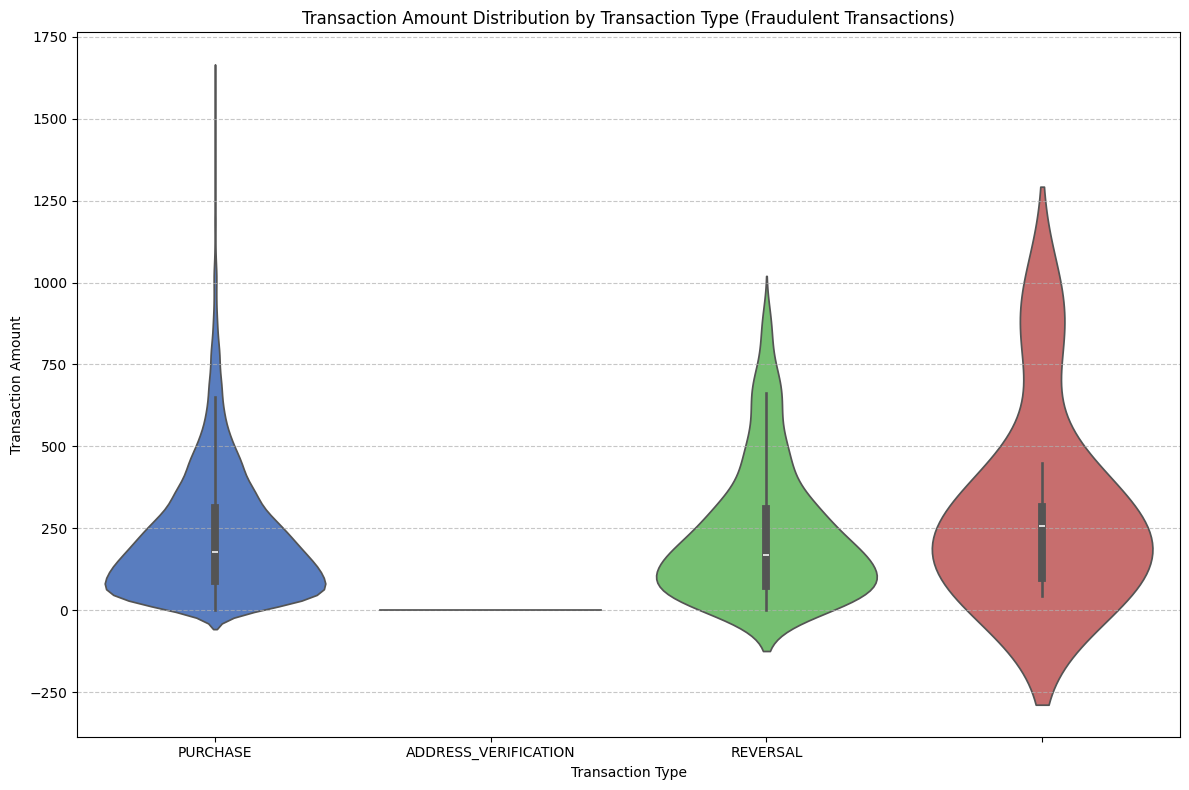

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter fraudulent transactions
fraudulent_transactions = df[df['isFraud'] == 1]

# Plotting the violin plot
plt.figure(figsize=(12, 8))
sns.violinplot(x='transactionType', y='transactionAmount', data=fraudulent_transactions, palette='muted')
plt.title('Transaction Amount Distribution by Transaction Type (Fraudulent Transactions)')
plt.xlabel('Transaction Type')
plt.ylabel('Transaction Amount')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



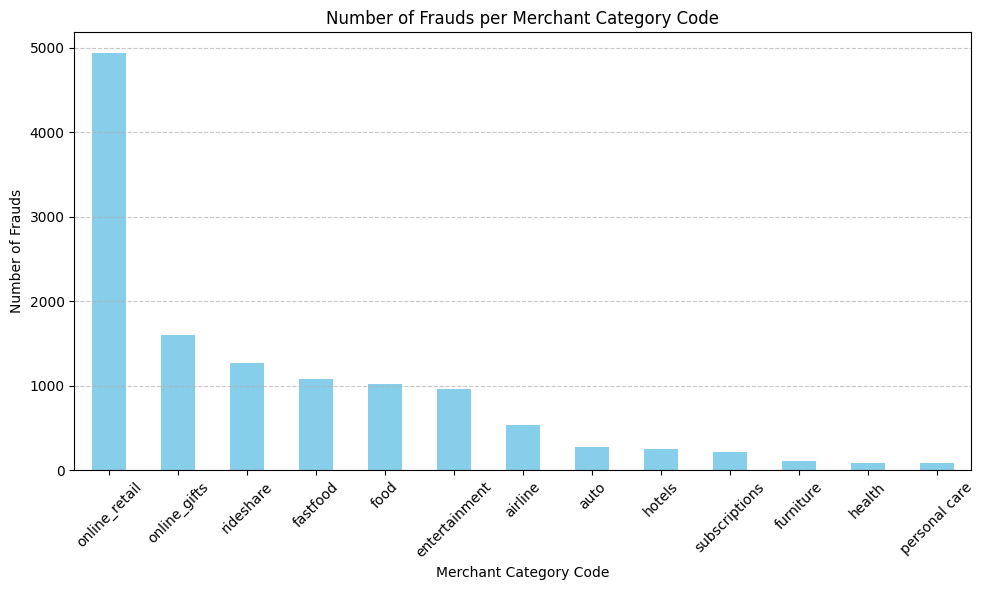

In [15]:
#Find the transaction amount per account number for transactions that are fraud
import matplotlib.pyplot as plt

# Group by merchantCategoryCode and count the number of frauds
fraud_per_merchant_category = df[df['isFraud'] == 1].groupby('merchantCategoryCode').size()

# Sort by the number of frauds in descending order
fraud_per_merchant_category = fraud_per_merchant_category.sort_values(ascending=False)

# Plotting the graph
plt.figure(figsize=(10, 6))
fraud_per_merchant_category.plot(kind='bar', color='skyblue')
plt.title('Number of Frauds per Merchant Category Code')
plt.xlabel('Merchant Category Code')
plt.ylabel('Number of Frauds')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

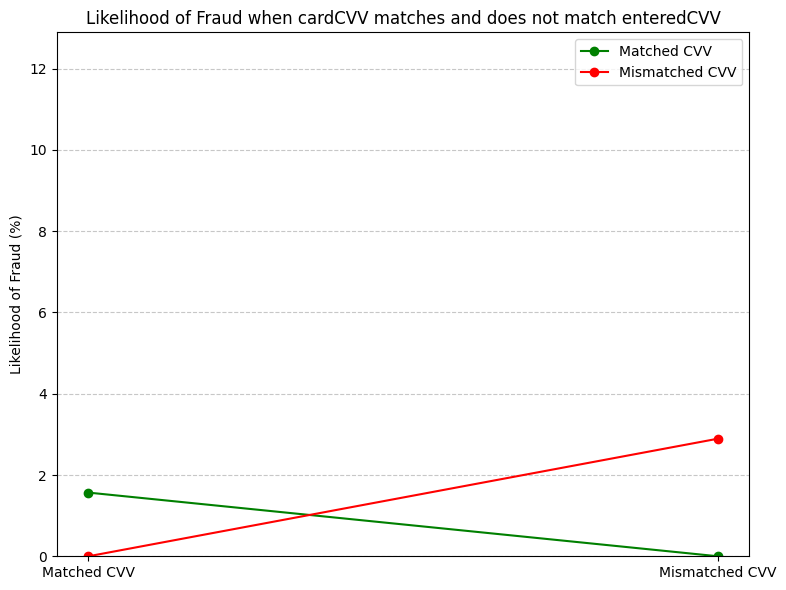

In [18]:
import matplotlib.pyplot as plt

# Total number of transactions where cardCVV matches enteredCVV
total_matched = len(df[df['cardCVV'] == df['enteredCVV']])

# Total number of fraud transactions where cardCVV matches enteredCVV
fraud_matched = len(df[(df['cardCVV'] == df['enteredCVV']) & (df['isFraud'] == 1)])

# Total number of transactions where cardCVV doesn't match enteredCVV
total_mismatch = len(df[df['cardCVV'] != df['enteredCVV']])

# Total number of fraud transactions where cardCVV doesn't match enteredCVV
fraud_mismatch = len(df[(df['cardCVV'] != df['enteredCVV']) & (df['isFraud'] == 1)])

# Calculate likelihood of fraud
likelihood_of_fraud_matched = (fraud_matched / total_matched) * 100
likelihood_of_fraud_mismatch = (fraud_mismatch / total_mismatch) * 100

# Plotting the line chart
plt.figure(figsize=(8, 6))
plt.plot(['Matched CVV', 'Mismatched CVV'], [likelihood_of_fraud_matched, 0], marker='o', label='Matched CVV', color='green')
plt.plot(['Matched CVV', 'Mismatched CVV'], [0, likelihood_of_fraud_mismatch], marker='o', label='Mismatched CVV', color='red')
plt.title('Likelihood of Fraud when cardCVV matches and does not match enteredCVV')
plt.ylabel('Likelihood of Fraud (%)')
plt.ylim(0, max(likelihood_of_fraud_matched, likelihood_of_fraud_mismatch) + 10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



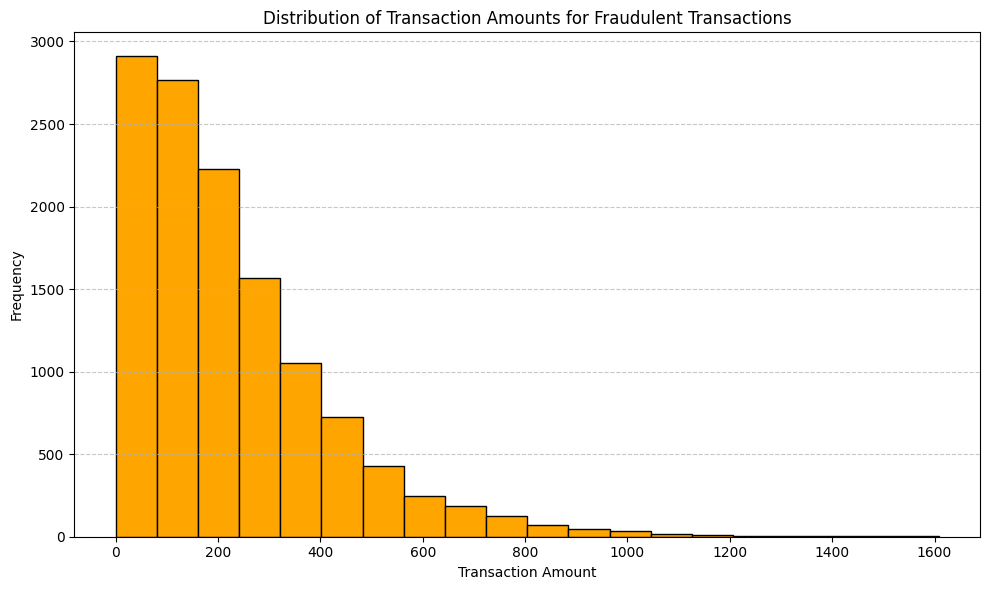

In [24]:
import matplotlib.pyplot as plt

# Filter out fraudulent transactions
fraudulent_transactions = df[df['isFraud'] == 1]['transactionAmount']

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(fraudulent_transactions, bins=20, color='orange', edgecolor='black')
plt.title('Distribution of Transaction Amounts for Fraudulent Transactions')
plt.xlabel('Transaction Amount')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



## Encoding

In [15]:
# Categorical columns that need to be endocded

columns_to_encode = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'merchantCategoryCode']
df = pd.get_dummies(df, columns=columns_to_encode, prefix=columns_to_encode)

# Convert boolean columns to integers
df['cardPresent'] = df['cardPresent'].astype(int)
df['expirationDateKeyInMatch'] = df['expirationDateKeyInMatch'].astype(int)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 777360 entries, 0 to 786362
Data columns (total 62 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   accountNumber                              777360 non-null  int64  
 1   creditLimit                                777360 non-null  int64  
 2   availableMoney                             777360 non-null  float64
 3   transactionAmount                          777360 non-null  float64
 4   cardCVV                                    777360 non-null  int64  
 5   enteredCVV                                 777360 non-null  int64  
 6   currentBalance                             777360 non-null  float64
 7   cardPresent                                777360 non-null  int32  
 8   expirationDateKeyInMatch                   777360 non-null  int32  
 9   isFraud                                    777360 non-null  bool   
 10  Month        

In [17]:
# Breaking apart features and labels

features = df.iloc[:, :-1]
labels = df['isFraud']

## Splitting dataset into train, test and val

In [18]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)


In [19]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

## Testing Function

In [20]:
# Function to test the model threshold to procude the best f1 score and produce results
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

def test_metrics(model, x_test, y_test):
    y_pred = model.predict(x_test)

    # Find the best threshold for F1 score
    thresholds = np.linspace(0, 1, 1001)
    f1_scores = []
    for thresh in thresholds:
        y_pred_binary = (y_pred >= thresh).astype(int)
        f1 = f1_score(y_test, y_pred_binary)
        f1_scores.append(f1)
    
    # Get the best threshold
    max_f1_index = np.argmax(f1_scores) 
    best_threshold = thresholds[max_f1_index]
    best_f1 = f1_scores[max_f1_index]

    # Use the best threshold to get final predictions
    y_pred_binary = (y_pred >= best_threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    auc = roc_auc_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred_binary)

    # Print metrics
    print(f"Best Threshold: {best_threshold}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1-Score: {best_f1}")
    print(f"AUC: {auc}")
    print("Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_binary)

    metrics = {
        'Best Threshold': best_threshold,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': best_f1,
        'AUC': auc,
        'Confusion Matrix': cm
    }
    return metrics
    

## Model Creation  
## Neural Network

In [21]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


model_1 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [22]:
model_1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [23]:

history = model_1.fit(x_train_scaled, y_train, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10

17005/17005 [==============================] - 19s 1ms/step - loss: 0.3465 - binary_accuracy: 0.9814 - recall: 0.0051 - val_loss: 0.0878 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 2/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0788 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0748 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 3/10
17005/17005 [==============================] - 20s 1ms/step - loss: 0.0769 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0749 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 4/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0761 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0748 - val_binary_accuracy: 0.9846 - val_recall: 0.0000e+00
Epoch 5/10
17005/17005 [==============================] - 18s 1ms/step - loss: 0.0759 - binary_accuracy: 0.9846 - recall: 0.0000e+00 - val_loss: 0.0758 - val_binary_accuracy: 

3644/3644 [==============================] - 2s 594us/step
Best Threshold: 0.054
Accuracy: 0.9514253370381806
Precision: 0.07157101706182141
Recall: 0.17974401780745689
F1-Score: 0.10237717908082408
AUC: 0.7450086140307604
Confusion Matrix:
[[110617   4190]
 [  1474    323]]


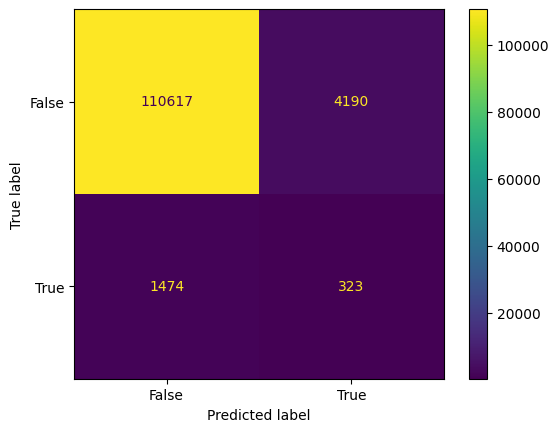

In [24]:
m1_test_results = test_metrics(model_1, x_test_scaled, y_test)

## Model Creation with SMOTE

In [25]:
np.random.seed(33)
tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

In [26]:
np.random.seed(33)
tf.random.set_seed(33)

#standardize/normalize numerical features

numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns 
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train_resampled)
x_train_scaled = x_train_scaled.astype('float32')
x_test_scaled = ct.transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

In [27]:
np.random.seed(33)
tf.random.set_seed(33)

model_2 = Sequential([
    Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [28]:
model_2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall()]
)

In [29]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_2.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.4562 - binary_accuracy: 0.8247 - recall_1: 0.8077 - val_loss: 0.5115 - val_binary_accuracy: 0.7371 - val_recall_1: 0.5899
Epoch 2/10
33486/33486 [==============================] - 31s 933us/step - loss: 0.2613 - binary_accuracy: 0.8927 - recall_1: 0.8408 - val_loss: 0.2156 - val_binary_accuracy: 0.9521 - val_recall_1: 0.1697
Epoch 3/10
33486/33486 [==============================] - 31s 931us/step - loss: 0.2434 - binary_accuracy: 0.9012 - recall_1: 0.8336 - val_loss: 0.1358 - val_binary_accuracy: 0.9841 - val_recall_1: 0.0050
Epoch 4/10
33486/33486 [==============================] - 31s 918us/step - loss: 0.2367 - binary_accuracy: 0.9036 - recall_1: 0.8431 - val_loss: 0.2744 - val_binary_accuracy: 0.9549 - val_recall_1: 0.1736
Epoch 5/10
33486/33486 [==============================] - 31s 936us/step - loss: 0.2785 - binary_accuracy: 0.8684 - recall_1: 0.7784 - val_loss: 0.1939 - val_binary_accuracy: 0.9741 

3644/3644 [==============================] - 2s 587us/step
Best Threshold: 0.432
Accuracy: 0.9605502384137765
Precision: 0.07824255191092386
Recall: 0.14468558708959378
F1-Score: 0.1015625
AUC: 0.7203993618692162
Confusion Matrix:
[[111744   3063]
 [  1537    260]]


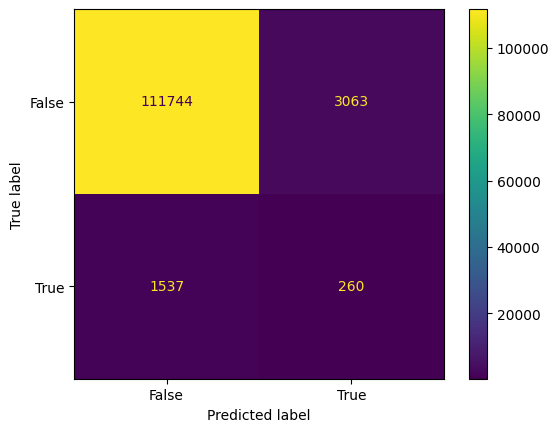

In [30]:
m2_test_results = test_metrics(model_2, x_test_scaled, y_test)

## Model 3
Adding an additional dense layer

In [31]:

model_3 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model_3.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [33]:

history = model_3.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.3982 - binary_accuracy: 0.8272 - recall_2: 0.7944 - precision: 0.8502 - val_loss: 0.2230 - val_binary_accuracy: 0.9575 - val_recall_2: 0.1575 - val_precision: 0.0760
Epoch 2/10
33486/33486 [==============================] - 33s 981us/step - loss: 0.2607 - binary_accuracy: 0.8933 - recall_2: 0.8291 - precision: 0.9512 - val_loss: 0.2141 - val_binary_accuracy: 0.9583 - val_recall_2: 0.1497 - val_precision: 0.0746
Epoch 3/10
33486/33486 [==============================] - 33s 998us/step - loss: 0.2425 - binary_accuracy: 0.9018 - recall_2: 0.8366 - precision: 0.9622 - val_loss: 0.0976 - val_binary_accuracy: 0.9846 - val_recall_2: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 33s 985us/step - loss: 0.2384 - binary_accuracy: 0.9041 - recall_2: 0.8379 - precision: 0.9658 - val_loss: 0.1949 - val_binary_accuracy: 0.9706 - val_recall_2: 0.0818 - val_precision: 0.076

3644/3644 [==============================] - 2s 585us/step
Best Threshold: 0.296
Accuracy: 0.9563651332715859
Precision: 0.07137275332117739
Recall: 0.15247634947134112
F1-Score: 0.09723207948899928
AUC: 0.7195189871750067
Confusion Matrix:
[[111242   3565]
 [  1523    274]]


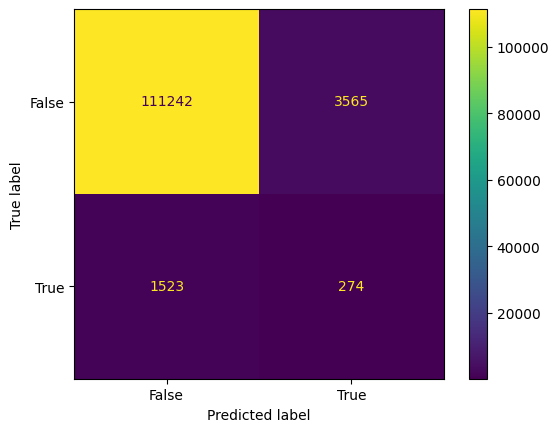

In [34]:
m3_test_results = test_metrics(model_3, x_test_scaled, y_test)

## Model 4
Testing model architecture with bias in fully connected layers

In [35]:
model_4 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],), use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [36]:
model_4.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [72]:
history = model_4.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4995 - recall_3: 0.5024 - precision_1: 0.4995 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_3: 0.5265 - precision_1: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_3: 0.0000e+00 - val_precision_1: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4998 - recall_3: 0.4784 - precision_1: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_precision_1: 0.0154
Epoch 4/10
33486/33486 [==============================] - 37s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4992 - recall_3: 0.5338 - precision_1: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_3: 1.0000 - val_

3644/3644 [==============================] - 3s 729us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


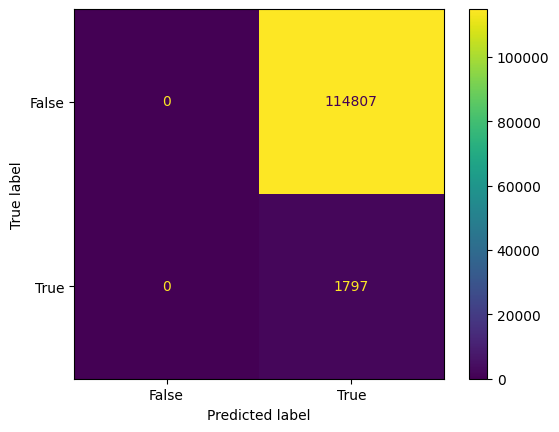

In [73]:
m4_test_results = test_metrics(model_4, x_test_scaled, y_test)

## Model 5
Adding drop out layers

In [39]:
model_5 = Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu',  use_bias=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [40]:
model_5.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [41]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_5.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.9023 - binary_accuracy: 0.4994 - recall_4: 0.5132 - precision_2: 0.4994 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 36s 1ms/step - loss: 0.6935 - binary_accuracy: 0.4995 - recall_4: 0.5237 - precision_2: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_4: 0.0000e+00 - val_precision_2: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.6934 - binary_accuracy: 0.4998 - recall_4: 0.4777 - precision_2: 0.4998 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_precision_2: 0.0154
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6932 - binary_accuracy: 0.4993 - recall_4: 0.5338 - precision_2: 0.4993 - val_loss: 0.7024 - val_binary_accuracy: 0.0154 - val_recall_4: 1.0000 - val_

3644/3644 [==============================] - 3s 717us/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


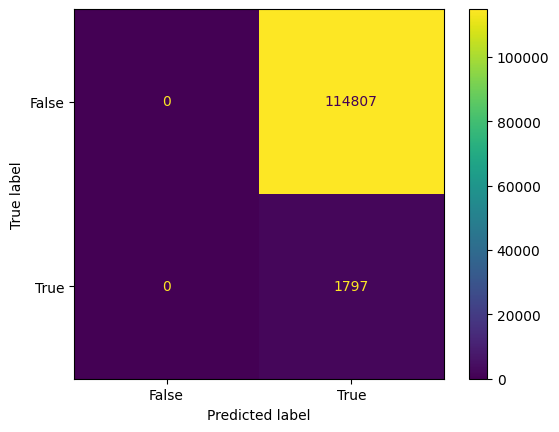

In [71]:
m5_test_results = test_metrics(model_5, x_test_scaled, y_test)

## Model 6
Switching to Leaky Relu as the activation function

In [43]:
model_6 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [44]:
model_6.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [45]:
history = model_6.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.6193 - binary_accuracy: 0.7685 - recall_5: 0.7402 - precision_3: 0.7846 - val_loss: 0.2376 - val_binary_accuracy: 0.9759 - val_recall_5: 0.0634 - val_precision_3: 0.0919
Epoch 2/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.2936 - binary_accuracy: 0.8750 - recall_5: 0.8160 - precision_3: 0.9252 - val_loss: 0.3750 - val_binary_accuracy: 0.8498 - val_recall_5: 0.4218 - val_precision_3: 0.0440
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2675 - binary_accuracy: 0.8881 - recall_5: 0.8271 - precision_3: 0.9421 - val_loss: 0.0763 - val_binary_accuracy: 0.9846 - val_recall_5: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2526 - binary_accuracy: 0.8952 - recall_5: 0.8336 - precision_3: 0.9508 - val_loss: 0.1818 - val_binary_accuracy: 0.9834 - val_recall_5: 0.0128 - val_precisio

3644/3644 [==============================] - 2s 619us/step
Best Threshold: 0.35000000000000003
Accuracy: 0.9383554595039622
Precision: 0.06220561961994478
Recall: 0.21313299944351696
F1-Score: 0.09630374654262007
AUC: 0.7178832982671036
Confusion Matrix:
[[109033   5774]
 [  1414    383]]


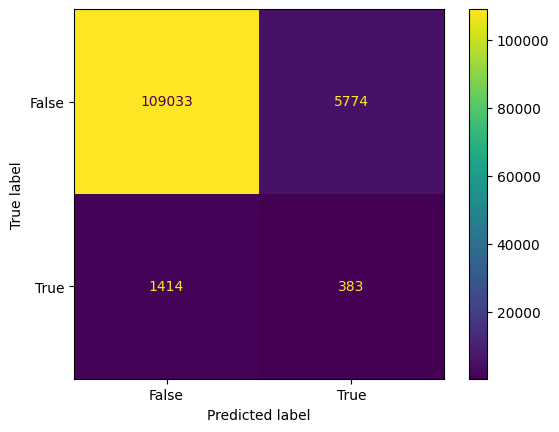

In [46]:
m6_test_results = test_metrics(model_6, x_test_scaled, y_test)

## Model 7
Adding another Dense layer

In [47]:
model_7 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [48]:
model_7.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [49]:
history = model_7.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6390 - binary_accuracy: 0.6799 - recall_6: 0.6546 - precision_4: 0.6894 - val_loss: 0.2690 - val_binary_accuracy: 0.9165 - val_recall_6: 0.2866 - val_precision_4: 0.0574
Epoch 2/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2993 - binary_accuracy: 0.8720 - recall_6: 0.8049 - precision_4: 0.9297 - val_loss: 0.1726 - val_binary_accuracy: 0.9826 - val_recall_6: 0.0200 - val_precision_4: 0.1180
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2728 - binary_accuracy: 0.8854 - recall_6: 0.8196 - precision_4: 0.9438 - val_loss: 0.1988 - val_binary_accuracy: 0.9833 - val_recall_6: 0.0122 - val_precision_4: 0.1164
Epoch 4/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.2581 - binary_accuracy: 0.8922 - recall_6: 0.8279 - precision_4: 0.9501 - val_loss: 0.2029 - val_binary_accuracy: 0.9769 - val_recall_6: 0.0573 - val_precision_4: 0.0

3644/3644 [==============================] - 2s 633us/step
Best Threshold: 0.341
Accuracy: 0.9460052828376385
Precision: 0.06682072020026959
Recall: 0.1930996104618809
F1-Score: 0.09928469241773963
AUC: 0.7200087350875216
Confusion Matrix:
[[109961   4846]
 [  1450    347]]


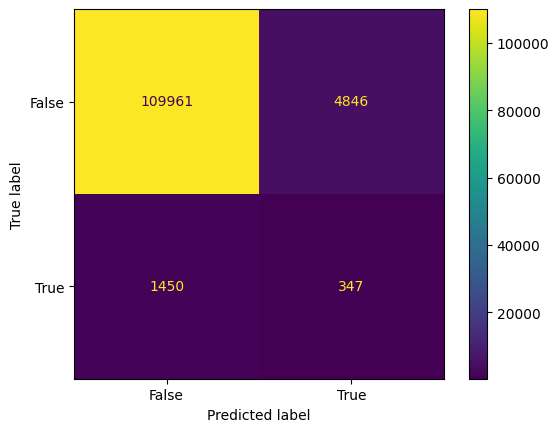

In [50]:
m7_test_results = test_metrics(model_7, x_test_scaled, y_test)

# Model 8
Adding more filters to the Dense layers

In [51]:
model_8 = Sequential([
    tf.keras.layers.Dense(64, input_shape=(x_train_scaled.shape[1],),  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32,  use_bias=True),
    tf.keras.layers.LeakyReLU(alpha=0.1),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid',  use_bias=True)
])

In [52]:
model_8.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(thresholds = 0.4), tf.keras.metrics.Precision()]
)

In [53]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_8.fit(x_train_scaled, y_train_resampled, 
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32,
                    )

Epoch 1/10
33486/33486 [==============================] - 40s 1ms/step - loss: 0.6020 - recall_7: 0.8724 - precision_5: 0.7024 - val_loss: 0.1738 - val_recall_7: 0.1408 - val_precision_5: 0.0911
Epoch 2/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2984 - recall_7: 0.8408 - precision_5: 0.9278 - val_loss: 0.0957 - val_recall_7: 0.0022 - val_precision_5: 0.1667
Epoch 3/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2705 - recall_7: 0.8451 - precision_5: 0.9458 - val_loss: 0.2044 - val_recall_7: 0.1308 - val_precision_5: 0.0962
Epoch 4/10
33486/33486 [==============================] - 39s 1ms/step - loss: 0.2566 - recall_7: 0.8509 - precision_5: 0.9524 - val_loss: 0.3031 - val_recall_7: 0.3272 - val_precision_5: 0.0574
Epoch 5/10
33486/33486 [==============================] - 38s 1ms/step - loss: 0.2458 - recall_7: 0.8576 - precision_5: 0.9552 - val_loss: 0.1441 - val_recall_7: 0.0902 - val_precision_5: 0.1035
Epoch 6/10
33486/33486 [=

3644/3644 [==============================] - 2s 639us/step
Best Threshold: 0.28600000000000003
Accuracy: 0.9619138279990395
Precision: 0.08138062064597847
Recall: 0.14301613800779076
F1-Score: 0.10373360242179616
AUC: 0.7239291976882798
Confusion Matrix:
[[111906   2901]
 [  1540    257]]


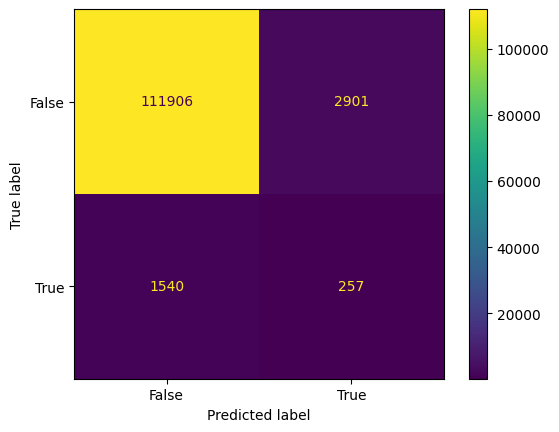

In [54]:
m8_test_results = test_metrics(model_8, x_test_scaled, y_test)

## Results ordering

In [55]:
all_results = {
    'model_1': m1_test_results,
    'model_2': m2_test_results,
    'model_3': m3_test_results,
    'model_4': m4_test_results,
    'model_5': m5_test_results,
    'model_6': m6_test_results,
    'model_7': m7_test_results,
    'model_8': m8_test_results,
}

In [56]:
results_df = pd.DataFrame.from_dict(all_results, orient='index')
sorted_df = results_df.sort_values(by='F1-Score', ascending=False)
sorted_df

,Best Threshold,Accuracy,Precision,Recall,F1-Score,AUC,Confusion Matrix
model_8,0.286,0.961914,0.081381,0.143016,0.103734,0.723929,"[[111906, 2901], [1540, 257]]"
model_1,0.054,0.951425,0.071571,0.179744,0.102377,0.745009,"[[110617, 4190], [1474, 323]]"
model_2,0.432,0.960550,0.078243,0.144686,0.101562,0.720399,"[[111744, 3063], [1537, 260]]"
model_7,0.341,0.946005,0.066821,0.193100,0.099285,0.720009,"[[109961, 4846], [1450, 347]]"
model_3,0.296,0.956365,0.071373,0.152476,0.097232,0.719519,"[[111242, 3565], [1523, 274]]"
model_6,0.350,0.938355,0.062206,0.213133,0.096304,0.717883,"[[109033, 5774], [1414, 383]]"
model_4,0.000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"
model_5,0.000,0.015411,0.015411,1.000000,0.030354,0.500000,"[[0, 114807], [0, 1797]]"


## RNN Model

### Process Overview: 

**After running the initial RNN model, we tested multiple variations of:** 
- modifying the metrics to with permutations of recall, precision, F1 score and accuracy -> including recall is best
- different thresholds for recall and precision -> recall below 0.4 causes every true positive to be caught with low precision
- decreasing the dropout rate -> 0.2 is best
- enhance the optimizer to include a learning rate (between 1e-3 and 1e-6) -> smaller is better
- decreasing the number of epochs because the model appears to be overtraining -> decreasing results after 3 epochs
- batch sizes of 16, 32, and 64 -> 32 is best
- using SMOTE and non-SMOTE training variables -> SMOTE is clearly better

From modifying these hyperparameters, computing time was not a significant consideration since we used a GPU. 
We prioritized the best results we could achieve over computing time.


### RNN Model - Initial

In [2]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [195]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [189]:
print(x_train_scaled.shape)
print(x_train_resampled.shape)
print(y_train_resampled.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(544152, 61)
(1071532, 61)
(1071532,)
(116604, 61)
(116604,)


In [196]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 217s 6ms/step - loss: 0.4673 - binary_accuracy: 0.7776 - recall_14: 0.7694 - precision_10: 0.7822 - val_loss: 1.4195 - val_binary_accuracy: 0.3267 - val_recall_14: 0.6984 - val_precision_10: 0.0158
Epoch 2/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4427 - binary_accuracy: 0.7912 - recall_14: 0.7836 - precision_10: 0.7958 - val_loss: 1.0081 - val_binary_accuracy: 0.5007 - val_recall_14: 0.5181 - val_precision_10: 0.0160
Epoch 3/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4373 - binary_accuracy: 0.7944 - recall_14: 0.7867 - precision_10: 0.7991 - val_loss: 0.8007 - val_binary_accuracy: 0.6017 - val_recall_14: 0.4101 - val_precision_10: 0.0160
Epoch 4/10
33486/33486 [==============================] - 212s 6ms/step - loss: 0.4338 - binary_accuracy: 0.7971 - recall_14: 0.7896 - precision_10: 0.8016 - val_loss: 0.6942 - val_binary_accuracy: 0.6605 - val_recall_14: 0.3467 - v

3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.5281379712531302
Precision: 0.01642680622183457
Recall: 0.5030606566499721
F1-Score: 0.031814742473033134
AUC: 0.5186243706799428
Confusion Matrix:
[[60679 54128]
 [  893   904]]


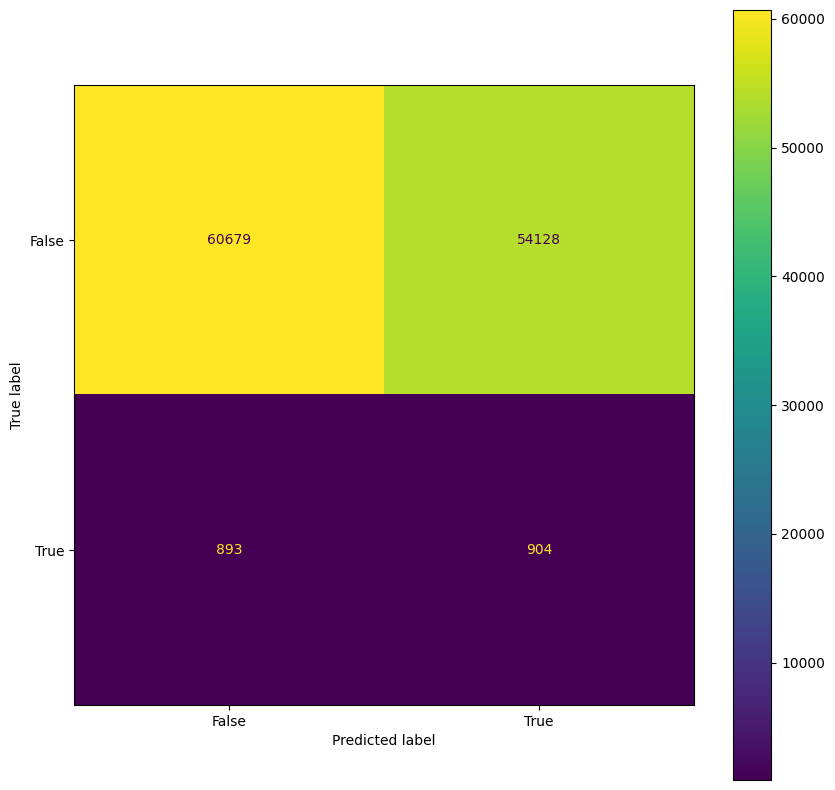

In [198]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN Model v2 - change the metrics to only recall and precision

In [25]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [26]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #####
)

In [27]:
print(x_train_scaled.shape)
print(x_train_resampled.shape)
print(y_train_resampled.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(1071532, 61)
(1071532, 61)
(1071532,)
(116604, 61)
(116604,)


In [28]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=10,
                    batch_size=32)

Epoch 1/10
33486/33486 [==============================] - 130s 4ms/step - loss: 0.4672 - recall: 0.7704 - precision: 0.7818 - val_loss: 1.4159 - val_recall: 0.6978 - val_precision: 0.0159
Epoch 2/10
33486/33486 [==============================] - 119s 4ms/step - loss: 0.4427 - recall: 0.7837 - precision: 0.7958 - val_loss: 1.0030 - val_recall: 0.5153 - val_precision: 0.0160
Epoch 3/10
33486/33486 [==============================] - 121s 4ms/step - loss: 0.4373 - recall: 0.7866 - precision: 0.7990 - val_loss: 0.7960 - val_recall: 0.4085 - val_precision: 0.0160
Epoch 4/10
33486/33486 [==============================] - 119s 4ms/step - loss: 0.4337 - recall: 0.7896 - precision: 0.8016 - val_loss: 0.6918 - val_recall: 0.3456 - val_precision: 0.0160
Epoch 5/10
33486/33486 [==============================] - 118s 4ms/step - loss: 0.4312 - recall: 0.7911 - precision: 0.8030 - val_loss: 0.5450 - val_recall: 0.2743 - val_precision: 0.0170
Epoch 6/10
33486/33486 [==============================] - 11

3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.5286868375012864
Precision: 0.016445932178722165
Recall: 0.5030606566499721
F1-Score: 0.031850612172993925
AUC: 0.5186431847668046
Confusion Matrix:
[[60743 54064]
 [  893   904]]


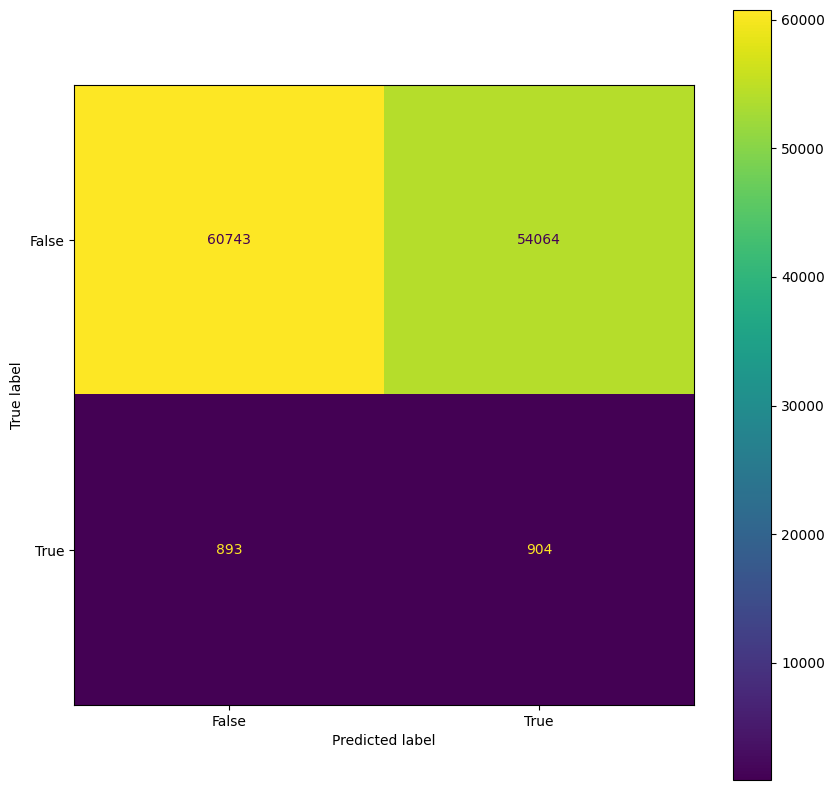

In [29]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN v3 - Decrease the number of epochs from 10 to 3 to prevent overtraining

In [31]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [32]:
model_r1.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #####
)

In [34]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 123s 4ms/step - loss: 0.4671 - recall_1: 0.7703 - precision_1: 0.7822 - val_loss: 1.4115 - val_recall_1: 0.6967 - val_precision_1: 0.0159
Epoch 2/3
33486/33486 [==============================] - 117s 4ms/step - loss: 0.4426 - recall_1: 0.7836 - precision_1: 0.7958 - val_loss: 0.9995 - val_recall_1: 0.5131 - val_precision_1: 0.0159
Epoch 3/3
33486/33486 [==============================] - 117s 4ms/step - loss: 0.4373 - recall_1: 0.7867 - precision_1: 0.7989 - val_loss: 0.7921 - val_recall_1: 0.4057 - val_precision_1: 0.0160


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.393939393939394
Accuracy: 0.50820726561696
Precision: 0.01640200585039699
Recall: 0.5242070116861436
F1-Score: 0.03180874233905688
AUC: 0.5191345128396485
Confusion Matrix:
[[58317 56490]
 [  855   942]]


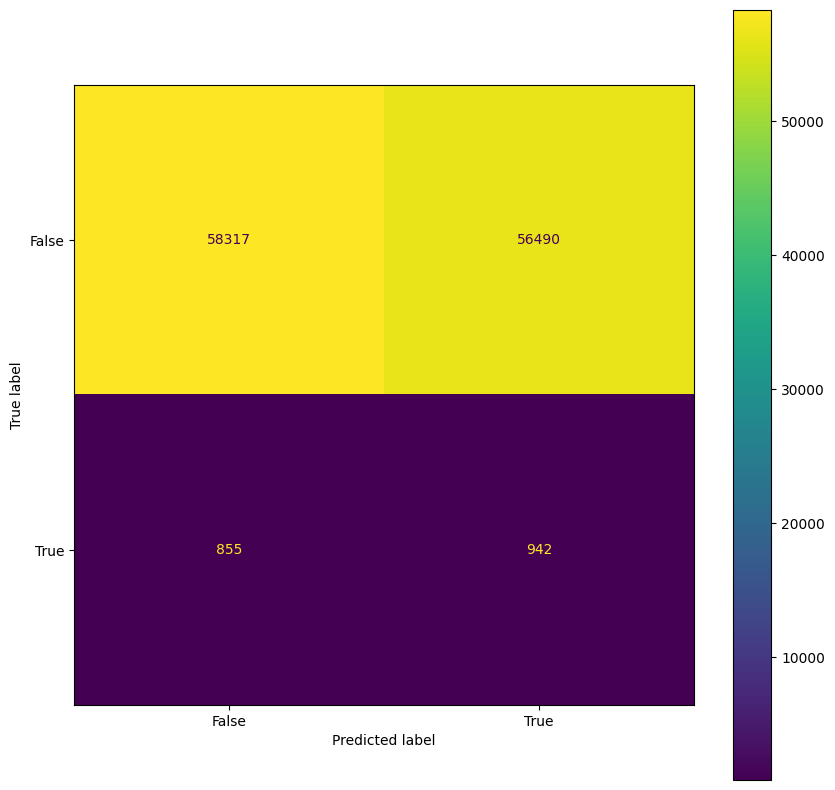

In [35]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN v4 - Use a learning rate with the optimizer

In [36]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [37]:
model_r1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #####
)

In [39]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 123s 4ms/step - loss: 0.4669 - recall_2: 0.7700 - precision_2: 0.7823 - val_loss: 1.4091 - val_recall_2: 0.6950 - val_precision_2: 0.0158
Epoch 2/3
33486/33486 [==============================] - 118s 4ms/step - loss: 0.4426 - recall_2: 0.7836 - precision_2: 0.7958 - val_loss: 0.9946 - val_recall_2: 0.5114 - val_precision_2: 0.0160
Epoch 3/3
33486/33486 [==============================] - 117s 4ms/step - loss: 0.4373 - recall_2: 0.7868 - precision_2: 0.7990 - val_loss: 0.7868 - val_recall_2: 0.4012 - val_precision_2: 0.0159


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.393939393939394
Accuracy: 0.51105450927927
Precision: 0.016361852708289538
Recall: 0.5197551474680022
F1-Score: 0.031725004670436985
AUC: 0.519146839059638
Confusion Matrix:
[[58657 56150]
 [  863   934]]


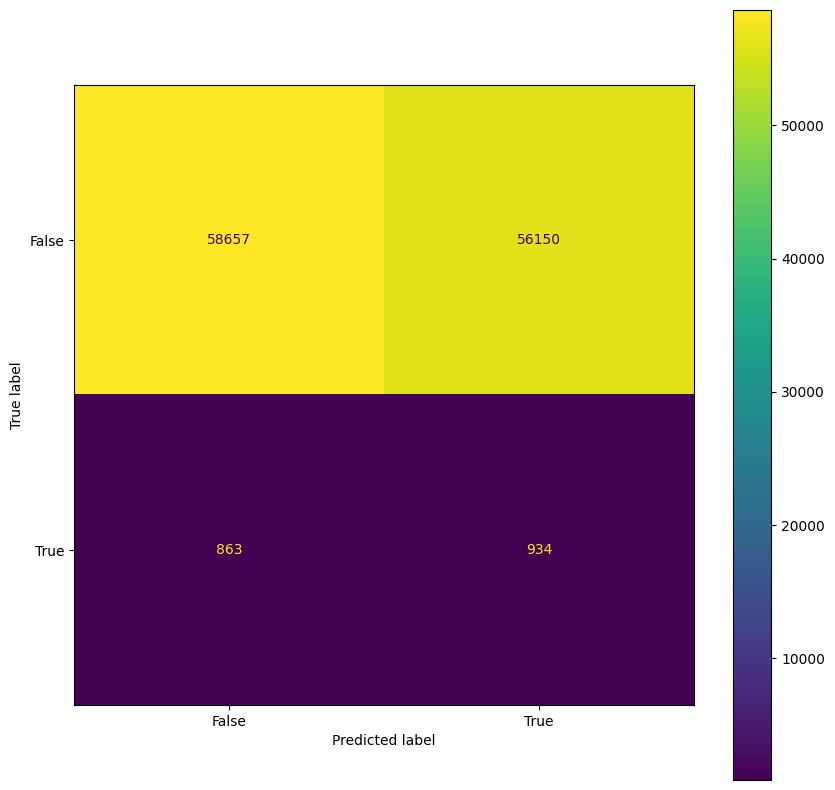

In [40]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN v5 - decrease the learning rate. Test recall thresholds of 0.4 and 0.45

In [55]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [64]:
model_r1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(thresholds = 0.4), tf.keras.metrics.Precision()] #####
)

### recall threshold of 0.4, learning rate = 1e-5

In [65]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 126s 4ms/step - loss: 0.5484 - recall_3: 0.8864 - precision_3: 0.7378 - val_loss: 0.8125 - val_recall_3: 0.7312 - val_precision_3: 0.0154
Epoch 2/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.5303 - recall_3: 0.8730 - precision_3: 0.7459 - val_loss: 0.8608 - val_recall_3: 0.7145 - val_precision_3: 0.0153
Epoch 3/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.5163 - recall_3: 0.8652 - precision_3: 0.7531 - val_loss: 0.9253 - val_recall_3: 0.7173 - val_precision_3: 0.0153


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.36363636363636365
Accuracy: 0.25716956536653973
Precision: 0.016209988364399627
Recall: 0.7907623817473567
F1-Score: 0.031768743223152505
AUC: 0.5167600311183009
Confusion Matrix:
[[28566 86241]
 [  376  1421]]


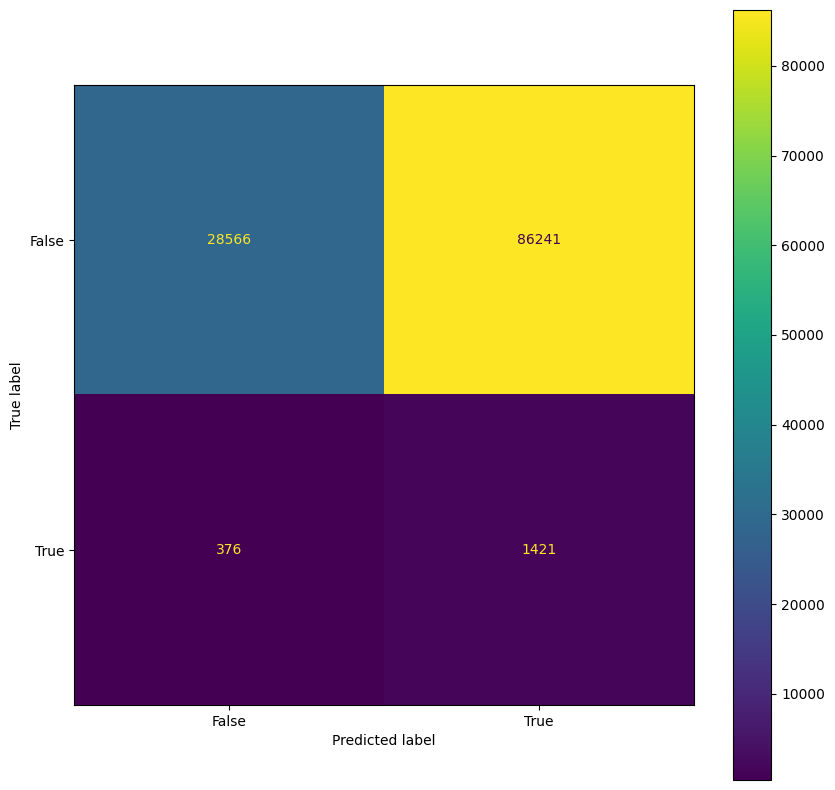

In [66]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### recall threshold of 0.45, learning rate = 1e-5

- There is a trade-off between accuracy and recall. 

In [61]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 126s 4ms/step - loss: 0.6367 - recall_1: 0.9268 - precision_1: 0.7128 - val_loss: 0.7050 - val_recall_1: 0.7540 - val_precision_1: 0.0157
Epoch 2/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.6024 - recall_1: 0.8691 - precision_1: 0.7200 - val_loss: 0.7284 - val_recall_1: 0.6750 - val_precision_1: 0.0157
Epoch 3/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.5722 - recall_1: 0.8390 - precision_1: 0.7289 - val_loss: 0.7762 - val_recall_1: 0.6600 - val_precision_1: 0.0155


3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.42424242424242425
Accuracy: 0.3073822510377002
Precision: 0.01623476076701587
Recall: 0.7373400111296605
F1-Score: 0.03177000911139884
AUC: 0.5192023288616202
Confusion Matrix:
[[34517 80290]
 [  472  1325]]


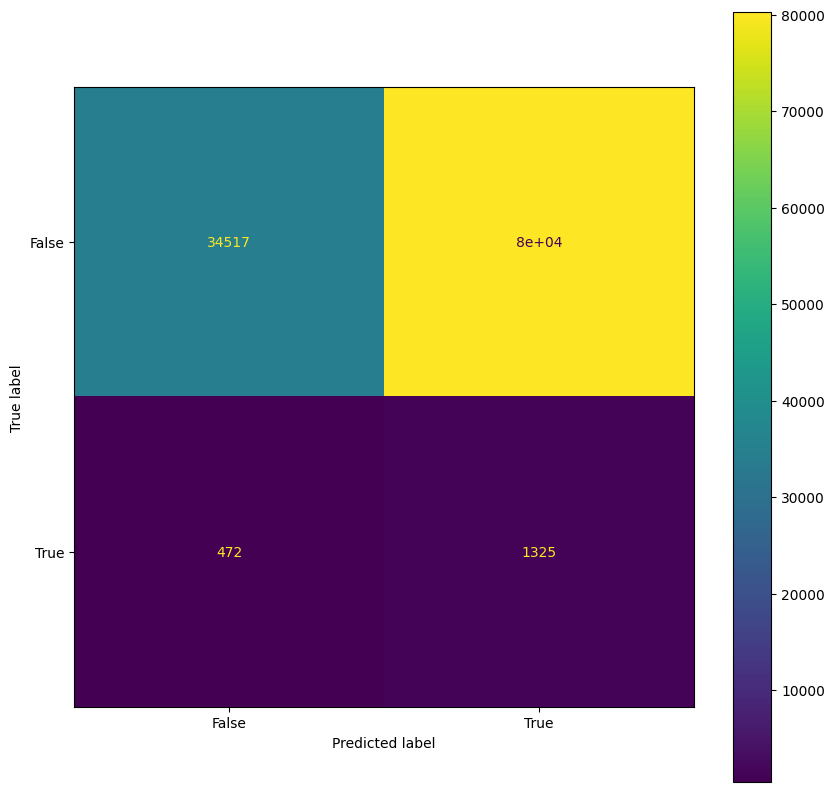

In [62]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN v6 - Decrease the batch size from 32 to 16. Increase the number of epochs.

In [46]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [47]:
model_r1.compile(
    #optimizer = 'adam',
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()] #####
)

In [49]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=5,
                    batch_size=16)

Epoch 1/5
66971/66971 [==============================] - 242s 4ms/step - loss: 0.6921 - recall_4: 0.2713 - precision_4: 0.5873 - val_loss: 0.6894 - val_recall_4: 0.1692 - val_precision_4: 0.0180
Epoch 2/5
66971/66971 [==============================] - 235s 4ms/step - loss: 0.6906 - recall_4: 0.4873 - precision_4: 0.6409 - val_loss: 0.6906 - val_recall_4: 0.3600 - val_precision_4: 0.0161
Epoch 3/5
66971/66971 [==============================] - 236s 4ms/step - loss: 0.6890 - recall_4: 0.5646 - precision_4: 0.6785 - val_loss: 0.6915 - val_recall_4: 0.4435 - val_precision_4: 0.0158
Epoch 4/5
66971/66971 [==============================] - 234s 4ms/step - loss: 0.6871 - recall_4: 0.6263 - precision_4: 0.6938 - val_loss: 0.6916 - val_recall_4: 0.4730 - val_precision_4: 0.0159
Epoch 5/5
66971/66971 [==============================] - 236s 4ms/step - loss: 0.6849 - recall_4: 0.6548 - precision_4: 0.7059 - val_loss: 0.6919 - val_recall_4: 0.4880 - val_precision_4: 0.0158


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.494949494949495
Accuracy: 0.3180336866659806
Precision: 0.01613646267820457
Recall: 0.7212020033388982
F1-Score: 0.03156664068589244
AUC: 0.5205048681080162
Confusion Matrix:
[[35788 79019]
 [  501  1296]]


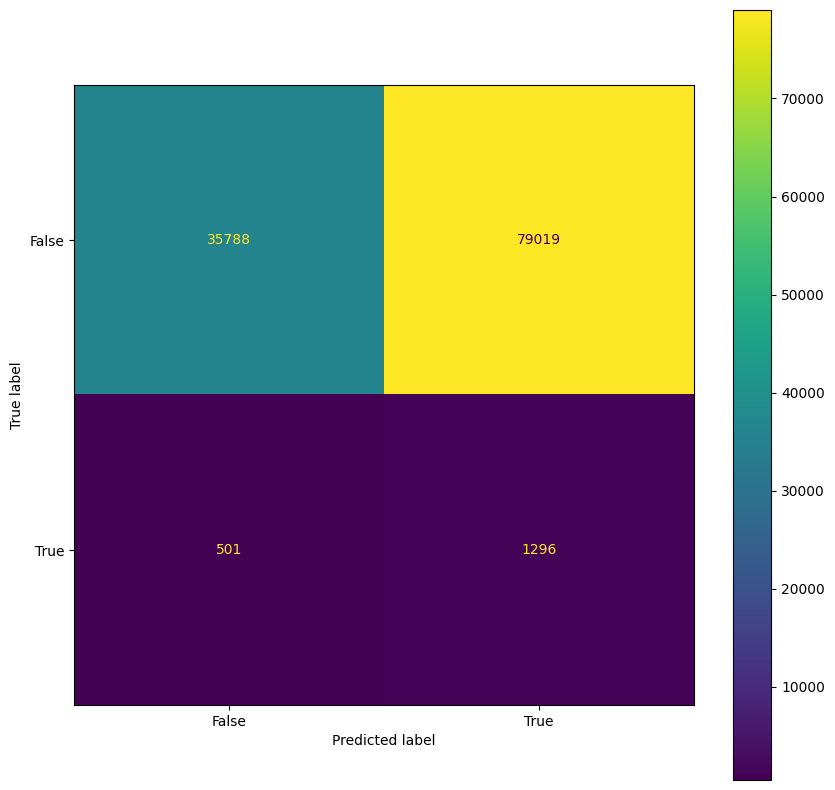

In [50]:
#import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

### RNN models using F1 as a metric

- We implemented a custom function for F1 to bypass errors from the keras.metrics.F1Score function

In [24]:
from keras import backend as K

In [25]:
embedding_dim = 32
max_features = 500000

model_r1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

#### Custom F1 function

In [26]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [47]:
metric_list = [f1_m, recall_m]

model_r1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics = metric_list
    #metrics=[tf.keras.metrics.F1Score(threshold=0.5)]
)

### RNN v7 - Add F1 as the metric without using SMOTE

In [32]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

np.random.seed(33)
tf.random.set_seed(33)

X = df.drop('isFraud', axis = 1)
Y = df['isFraud']

x_train, x_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=33, stratify=Y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=33, stratify=y_temp)

In [33]:
#standardize/normalize your numerical features
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
#numerical_features = features.select_dtypes(include=['float32', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

#Fit your instance ct of ColumnTransformer to the training data and at the same time transform it by using the ColumnTransformer.fit_transform()
x_train_scaled = ct.fit_transform(x_train)
x_train_scaled = x_train_scaled.astype('float32')

x_test_scaled = ct.transform(x_test) #Transform your test data instance features_test
x_test_scaled = x_test_scaled.astype('float32')
x_val_scaled = ct.transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

In [35]:
print(x_train_scaled.shape)
#print(x_train_resampled.shape)
print(y_train.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(544152, 61)
(544152,)
(116604, 61)
(116604,)


In [36]:
history_unbalanced = model_r1.fit(x_train_scaled, y_train,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
17005/17005 [==============================] - 66s 4ms/step - loss: 0.0846 - f1_m: 0.0000e+00 - val_loss: 0.0796 - val_f1_m: 0.0000e+00
Epoch 2/3
17005/17005 [==============================] - 63s 4ms/step - loss: 0.0806 - f1_m: 0.0000e+00 - val_loss: 0.0802 - val_f1_m: 0.0000e+00
Epoch 3/3
17005/17005 [==============================] - 62s 4ms/step - loss: 0.0804 - f1_m: 0.0000e+00 - val_loss: 0.0794 - val_f1_m: 0.0000e+00


### RNN v8 - Add F1 score, use SMOTE

In [48]:
np.random.seed(33)
#tf.random.set_seed(33)
# Applying SMOTE to address the class imbalance
smote = SMOTE(sampling_strategy='auto', random_state=33)
x_train_resampled, y_train_resampled = smote.fit_resample(x_train, y_train)

x_train_resampled = x_train_resampled.astype('float32')
y_train_resampled = y_train_resampled.astype('float32')

In [49]:
########
#np.random.seed(33)
#tf.random.set_seed(33)
#########

#standardize/normalize your numerical features

#use DataFrame.select_dtypes() to select float64 or int64 feature types automatically.
numerical_features = features.select_dtypes(include=['float64', 'int64'])
numerical_columns = numerical_features.columns # Get a list of the column names
ct = ColumnTransformer([("only numeric", StandardScaler(), numerical_columns)], remainder='passthrough')

x_train_scaled = ct.fit_transform(x_train_resampled)
x_train_scaled = x_train_scaled.astype('float32')

x_test_scaled = ct.fit_transform(x_test)
x_test_scaled = x_test_scaled.astype('float32')

x_val_scaled = ct.fit_transform(x_val)
x_val_scaled = x_val_scaled.astype('float32')

In [50]:
print(x_train_scaled.shape)
print(x_train_resampled.shape)
print(y_train_resampled.shape)
print(x_val_scaled.shape)
print(y_val.shape)

(1071532, 61)
(1071532, 61)
(1071532,)
(116604, 61)
(116604,)


#### Using 6 epochs

In [53]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=6,
                    batch_size=32)

Epoch 1/6
33486/33486 [==============================] - 124s 4ms/step - loss: 0.4205 - f1_m: 0.7990 - recall_m: 0.7985 - val_loss: 0.3170 - val_f1_m: 0.0252 - val_recall_m: 0.0529
Epoch 2/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4204 - f1_m: 0.7987 - recall_m: 0.7981 - val_loss: 0.3170 - val_f1_m: 0.0247 - val_recall_m: 0.0520
Epoch 3/6
33486/33486 [==============================] - 123s 4ms/step - loss: 0.4201 - f1_m: 0.7991 - recall_m: 0.7986 - val_loss: 0.3220 - val_f1_m: 0.0253 - val_recall_m: 0.0537
Epoch 4/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4203 - f1_m: 0.7990 - recall_m: 0.7987 - val_loss: 0.3186 - val_f1_m: 0.0248 - val_recall_m: 0.0526
Epoch 5/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4204 - f1_m: 0.7985 - recall_m: 0.7975 - val_loss: 0.3185 - val_f1_m: 0.0247 - val_recall_m: 0.0523
Epoch 6/6
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4203 - f1_m: 0

3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.5080100168090288
Precision: 0.01637860512070736
Recall: 0.523650528658876
F1-Score: 0.03176371308016878
AUC: 0.518328226337551
Confusion Matrix:
[[58295 56512]
 [  856   941]]


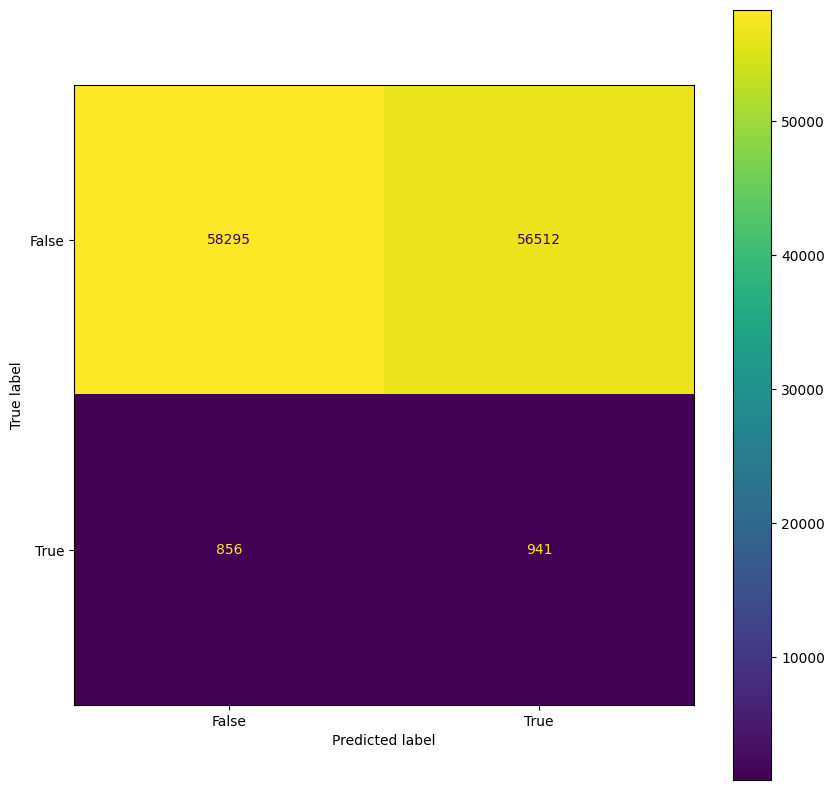

In [54]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

#### Using 3 epochs

In [51]:
#np.random.seed(33)
#tf.random.set_seed(33)

history = model_r1.fit(x_train_resampled, y_train_resampled,
                    validation_data=(x_val_scaled, y_val),
                    epochs=3,
                    batch_size=32)

Epoch 1/3
33486/33486 [==============================] - 128s 4ms/step - loss: 0.4025 - f1_m: 0.8110 - recall_m: 0.8101 - val_loss: 0.3196 - val_f1_m: 0.0251 - val_recall_m: 0.0531
Epoch 2/3
33486/33486 [==============================] - 121s 4ms/step - loss: 0.4067 - f1_m: 0.8083 - recall_m: 0.8078 - val_loss: 0.3177 - val_f1_m: 0.0253 - val_recall_m: 0.0530
Epoch 3/3
33486/33486 [==============================] - 122s 4ms/step - loss: 0.4061 - f1_m: 0.8086 - recall_m: 0.8077 - val_loss: 0.3241 - val_f1_m: 0.0252 - val_recall_m: 0.0537


3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.10101010101010102
Accuracy: 0.49325923638983227
Precision: 0.01634389720904317
Recall: 0.5386755703951029
F1-Score: 0.03172522286313581
AUC: 0.5185021821165898
Confusion Matrix:
[[56548 58259]
 [  829   968]]


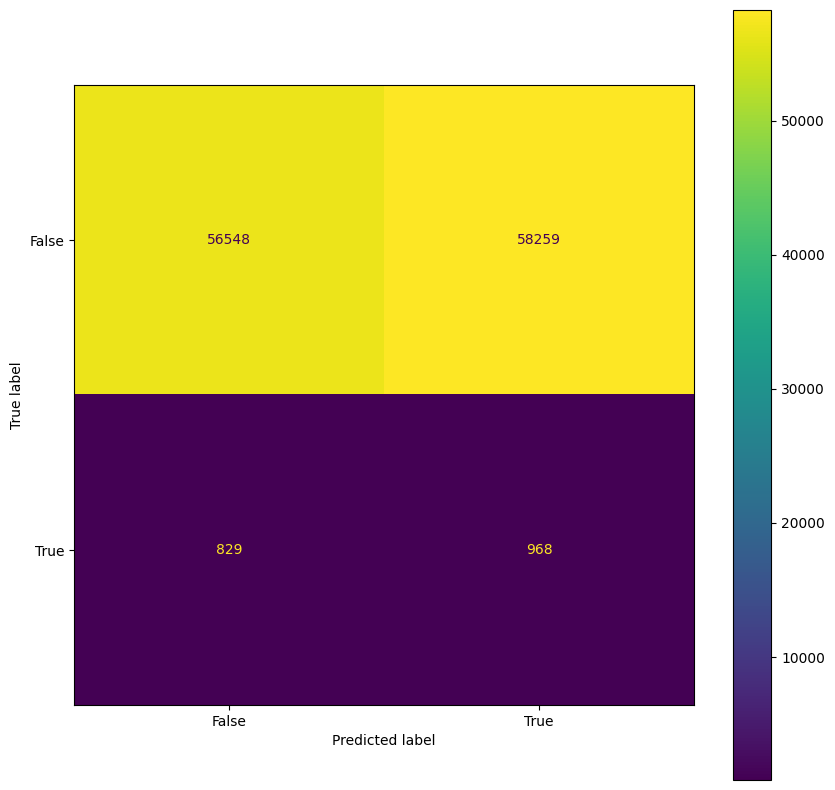

In [52]:
plt.rcParams["figure.figsize"] = (10,10)

RNN1_test_results = test_metrics(model_r1, x_test_scaled, y_test)

## LSTM

In [52]:
#Reshape for model
X_train_reshaped = features_train_scaled.reshape(features_train_scaled.shape[0], 1, features_train_scaled.shape[1])
x_val_reshaped = x_val_scaled.reshape(x_val_scaled.shape[0], 1, x_val_scaled.shape[1])


model = Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(1, features_train_scaled.shape[1])),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [53]:
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['binary_accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [54]:

history = model.fit(X_train_reshaped, labels_train,
                    validation_data=(x_val_scaled.reshape(x_val_scaled.shape[0], 1, x_val_scaled.shape[1]), y_val),
                    epochs=5,
                    batch_size=32, verbose=1)

Epoch 1/5
16465/16465 [==============================] - 123s 7ms/step - loss: 0.0784 - binary_accuracy: 0.9840 - recall_2: 0.0027 - precision_2: 0.2255 - val_loss: 0.0728 - val_binary_accuracy: 0.9842 - val_recall_2: 0.0199 - val_precision_2: 0.9040
Epoch 2/5
16465/16465 [==============================] - 108s 7ms/step - loss: 0.0728 - binary_accuracy: 0.9844 - recall_2: 0.0191 - precision_2: 0.8511 - val_loss: 0.0714 - val_binary_accuracy: 0.9842 - val_recall_2: 0.0243 - val_precision_2: 0.8263
Epoch 3/5
16465/16465 [==============================] - 107s 7ms/step - loss: 0.0714 - binary_accuracy: 0.9844 - recall_2: 0.0217 - precision_2: 0.8311 - val_loss: 0.0696 - val_binary_accuracy: 0.9842 - val_recall_2: 0.0241 - val_precision_2: 0.8354
Epoch 4/5
16465/16465 [==============================] - 108s 7ms/step - loss: 0.0705 - binary_accuracy: 0.9844 - recall_2: 0.0263 - precision_2: 0.7407 - val_loss: 0.0691 - val_binary_accuracy: 0.9842 - val_recall_2: 0.0321 - val_precision_2: 0.7

# Additional LSTM attempts

In [57]:
x_train_reshaped = np.expand_dims(x_train_scaled, axis=1)
x_val_reshaped = np.expand_dims(x_val_scaled, axis=1)
x_test_reshaped = np.expand_dims(x_test_scaled, axis = 1)

In [58]:
x_train_scaled.shape

(1071532, 61)

In [59]:
x_train_reshaped.shape

(1071532, 1, 61)

In [60]:
x_val_reshaped.shape

(116604, 1, 61)

## Additional LSTM attempt 1

In [61]:
num_features = x_train_scaled.shape[1]

model_r1 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [62]:
model_r1.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [63]:
np.random.seed(33)
tf.random.set_seed(33)


history = model_r1.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=10,
                    batch_size=32,
                    )

Epoch 1/10
33486/33486 [==============================] - 84s 2ms/step - loss: 0.6932 - binary_accuracy: 0.5004 - recall_8: 0.5232 - precision_6: 0.5004 - val_loss: 0.6896 - val_binary_accuracy: 0.9846 - val_recall_8: 0.0000e+00 - val_precision_6: 0.0000e+00
Epoch 2/10
33486/33486 [==============================] - 81s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4996 - recall_8: 0.5266 - precision_6: 0.4996 - val_loss: 0.6896 - val_binary_accuracy: 0.9846 - val_recall_8: 0.0000e+00 - val_precision_6: 0.0000e+00
Epoch 3/10
33486/33486 [==============================] - 80s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4996 - recall_8: 0.4775 - precision_6: 0.4996 - val_loss: 0.7042 - val_binary_accuracy: 0.0154 - val_recall_8: 1.0000 - val_precision_6: 0.0154
Epoch 4/10
33486/33486 [==============================] - 80s 2ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_8: 0.5222 - precision_6: 0.4994 - val_loss: 0.7028 - val_binary_accuracy: 0.0154 - val_recall_8: 1.0000 - val_

3644/3644 [==============================] - 5s 1ms/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


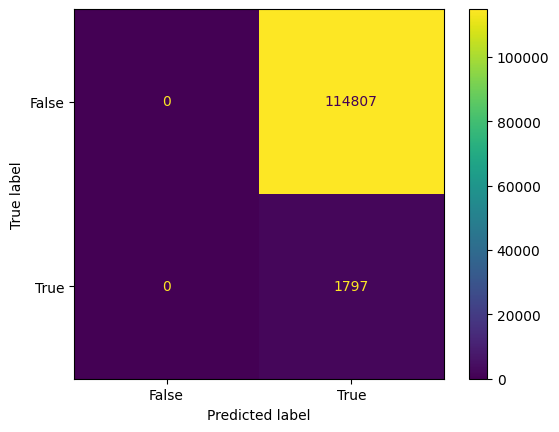

In [70]:
r1_test_results = test_metrics(model_r1, x_test_reshaped, y_test)

## Additional LSTM attempt 2
Adding dense layer and Global Average Pooling

In [65]:
num_features = x_train_scaled.shape[1]

model_r2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(None, num_features)),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(50, return_sequences=True),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'), 
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


In [66]:
model_r2.compile(
    optimizer = 'adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [67]:
np.random.seed(33)
tf.random.set_seed(33)

history = model_r2.fit(x_train_reshaped, y_train_resampled, 
                    validation_data=(x_val_reshaped, y_val),
                    epochs=3,
                    batch_size=32
                    )

Epoch 1/3
33486/33486 [==============================] - 97s 3ms/step - loss: 0.6932 - binary_accuracy: 0.5002 - recall_9: 0.5206 - precision_7: 0.5002 - val_loss: 0.6895 - val_binary_accuracy: 0.9846 - val_recall_9: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 2/3
33486/33486 [==============================] - 93s 3ms/step - loss: 0.6932 - binary_accuracy: 0.4994 - recall_9: 0.5265 - precision_7: 0.4995 - val_loss: 0.6905 - val_binary_accuracy: 0.9846 - val_recall_9: 0.0000e+00 - val_precision_7: 0.0000e+00
Epoch 3/3
33486/33486 [==============================] - 92s 3ms/step - loss: 0.6932 - binary_accuracy: 0.4997 - recall_9: 0.4865 - precision_7: 0.4997 - val_loss: 0.7048 - val_binary_accuracy: 0.0154 - val_recall_9: 1.0000 - val_precision_7: 0.0154


3644/3644 [==============================] - 4s 1ms/step
Best Threshold: 0.0
Accuracy: 0.015411135124009469
Precision: 0.015411135124009469
Recall: 1.0
F1-Score: 0.030354473357488535
AUC: 0.5
Confusion Matrix:
[[     0 114807]
 [     0   1797]]


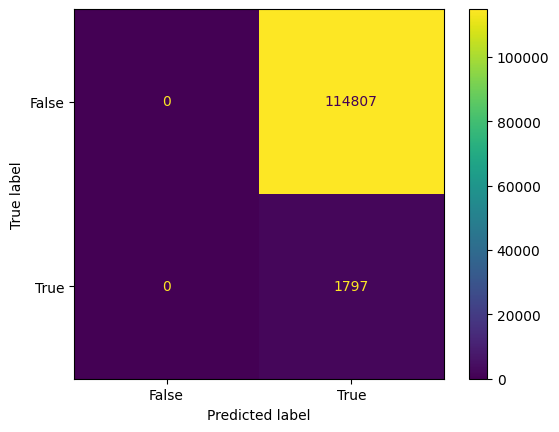

In [69]:
r2_test_results = test_metrics(model_r2, x_test_reshaped, y_test)

## Additional work started for Future Solutions

## Hyperparameter tuning

We set hyperparameters to some initial values. We fit the model to the training data and check how it performs on the validation data by looking at accuracy for classification:

* the learning rate
* number of batches
* number of epochs
* number of units per hidden layer


## Tuning: Learning Rate

The learning rate determines how big of a change you apply to the network weights as a consequence of the error gradient calculated on a batch of training data.

A larger learning rate leads to a faster learning process at a cost to be stuck in a suboptimal solution (local minimum). A smaller learning rate might produce a good suboptimal or global solution, but it will take it much longer to converge. In the extremes, a learning rate too large will lead to an unstable learning process oscillating over the epochs. A learning rate too small may not converge or get stuck in a local minimum.

In [ ]:
from tensorflow	import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers

from sklearn.metrics import r2_score

Epoch 1/15
49394/49394 [==============================] - 165s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 2/15
49394/49394 [==============================] - 162s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 3/15
49394/49394 [==============================] - 164s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 4/15
49394/49394 [==============================] - 164s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 5/15
49394/49394 [==============================] - 162s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 6/15
49394/49394 [==============================] - 160s 3ms/step - loss: 0.2458 - binary_accuracy: 0.9841 - val_loss: 0.2436 - val_binary_accuracy: 0.9842
Epoch 7/15
49394/49394 [====

KeyError: 'val_binarycross'

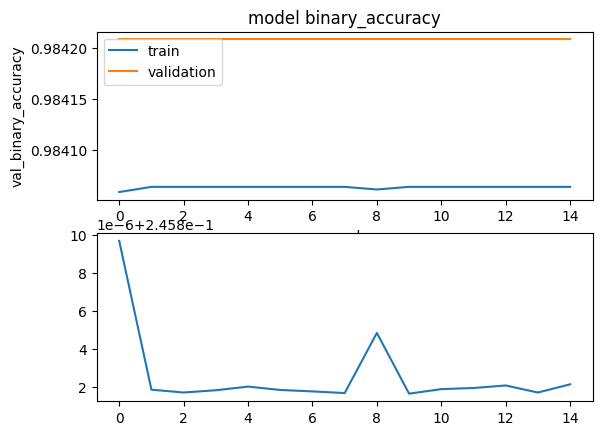

In [ ]:
# function to design the model
def design_model(feature_data):
	model = Sequential()
	num_features = feature_data.shape[1]
	input = tf.keras.Input(shape=(num_features))
	model.add(input)
	# this model has two hidden layers and two dropout layers
	# relu activation function is used at both hidden layers
	hidden_layer = layers.Dense(64, activation='relu')
	model.add(hidden_layer)
	model.add(layers.Dropout(0.1))
	hidden_layer_2 = layers.Dense(32, activation='relu')
	model.add(hidden_layer_2)
	model.add(layers.Dropout(0.2))
	model.add(layers.Dense(1))

	# using an adam optimizer with a learning rate of 0.005
	# using mean-squared error as our loss function and mean average error as our metric
	opt = keras.optimizers.Adam(learning_rate=0.005)
	model.compile(loss='binary_crossentropy', metrics=[tf.keras.metrics.BinaryAccuracy()], optimizer=opt)
	return model

# apply the model to the scaled training data
model = design_model(features_train_scaled)
#print(model.summary())

# apply early stopping for efficiency
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

# fit the model with 15 epochs and a batch size of 8
# validation split at 0.25
history = model.fit(features_train_scaled, labels_train.to_numpy(), epochs=15, batch_size=8, verbose=1, validation_split=0.25, callbacks=[es])

# evaluate the model
val_binarycross, val_binary_accuracy = model.evaluate(features_test_scaled, labels_test.to_numpy(), verbose = 0)

# view the BinaryAccuracy performance
print("BinaryAccuracy: ", val_binary_accuracy)

# evauate r-squared score
y_pred = model.predict(features_test_scaled)

# plot binary_accuracy and val_binary_accuracy over each epoch
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model binary_accuracy')
ax1.set_ylabel('val_binary_accuracy')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'validation'], loc='upper left')

# Plot loss and binary_crossentropy over each epoch
ax2 = fig.add_subplot(2, 1, 2)
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_binarycross'])
ax2.set_title('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'validation'], loc='upper left')

plt.show()

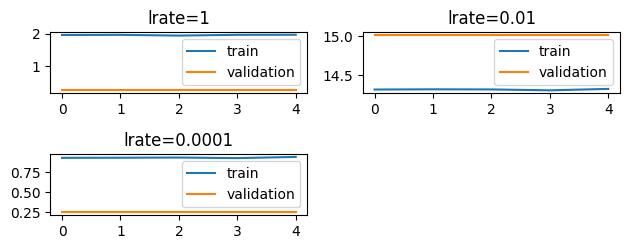

In [ ]:
def fit_model(f_train, l_train, learning_rate, num_epochs, bs):
    #build the model
    model = design_model(f_train)
    #train the model on the training data
    history = model.fit(f_train, l_train, epochs = num_epochs, batch_size = bs, verbose = 0, validation_split = 0.2)
    # plot learning curves
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('lrate=' + str(learning_rate))
    plt.legend(loc="upper right")


#make a list of learning rates to try out
learning_rates = [1, 1E-2, 1E-4]
#fixed number of epochs
num_epochs = 5
#fixed number of batches
batch_size = 32

for i in range(len(learning_rates)):
  plot_no = 420 + (i+1)
  plt.subplot(plot_no)
  fit_model(features_train, labels_train, learning_rates[i], num_epochs, batch_size)

plt.tight_layout()
plt.show()
